Final Project OMICS part 2
Chairetaki Antonia
December 2025
Master in Bioinformatics
Medical School of Crete

Transient N-6-Methyladenosine Transcriptome Sequencing Reveals a Regulatory Role of m6A in Splicing Efficiency
Reproduction of Figure 1C-F

First, I downloaded and extracted the raw BigWig data files from GSE92565 and GSE54365, along with the human genome annotation file (hg19) from GENCODE (gencode.v19.annotation.gtf.gz). The GSE92565 dataset contains the nascent RNA signal (TNT-seq) to identify early m6A deposition, the GSE54365 dataset provides the steady-state control (m6A-seq) to compare against mature mRNA, and the GTF file serves as the coordinate map to locate the specific splice sites and codons needed for the analysis.

Then, I parse the genome annotation file (GTF) and extract the coordinates for: Start Codons, Stop Codons, 5' and 3' Splice Sites. The script calculates the exact boundaries of the exons to locate the splice junctions and saves these positions into BED files.

In [ ]:
import gffutils

# 1. Create Database
print("Building database...")
db = gffutils.create_db("gencode.v19.annotation.gtf", "genes.db", 
                        force=True, disable_infer_genes=True, disable_infer_transcripts=True)

# 2. Open output files
files = {
    "start": open("starts_quick.bed", "w"),
    "stop":  open("stops_quick.bed", "w"),
    "ss5":   open("ss5_quick.bed", "w"),
    "ss3":   open("ss3_quick.bed", "w")
}

print("Extracting coordinates (Both Strands)...")

count = 0
limit = 20000 

for gene in db.features_of_type("gene"):
    if count >= limit: break
    if gene["gene_type"][0] != "protein_coding": continue

    # Ensure chromosome names match BigWigs (add 'chr')
    chrom = gene.chrom
    if not chrom.startswith("chr"): chrom = f"chr{chrom}"
    strand = gene.strand

    for transcript in db.children(gene, featuretype="transcript"):
        
        # Start/Stop Codons: Subtract 1 from start for 0-based BED format
        for feat_type in ["start_codon", "stop_codon"]:
            for feat in db.children(transcript, featuretype=feat_type):
                key = "start" if feat_type == "start_codon" else "stop"
                files[key].write(f"{chrom}\t{feat.start - 1}\t{feat.end}\t{gene.id}\t.\t{strand}\n")

        # Splice Sites
        exons = list(db.children(transcript, featuretype="exon", order_by="start"))
        if len(exons) < 2: continue
        
        for i in range(len(exons)-1):
            if strand == "+":
                # Plus Strand: 5'SS is Exon End, 3'SS is Next Exon Start
                e_curr, e_next = exons[i], exons[i+1]
                files["ss5"].write(f"{chrom}\t{e_curr.end - 1}\t{e_curr.end}\t{gene.id}\t.\t+\n")
                files["ss3"].write(f"{chrom}\t{e_next.start - 1}\t{e_next.start}\t{gene.id}\t.\t+\n")
            
            elif strand == "-":
                # Minus Strand: Logic is reversed (Transcription is Right -> Left)
                # 5'SS is Start of Right Exon; 3'SS is End of Left Exon
                e_right, e_left = exons[i+1], exons[i]
                files["ss5"].write(f"{chrom}\t{e_right.start - 1}\t{e_right.start}\t{gene.id}\t.\t-\n")
                files["ss3"].write(f"{chrom}\t{e_left.end - 1}\t{e_left.end}\t{gene.id}\t.\t-\n")

    count += 1

for f in files.values(): f.close()
print("Success! Created: starts_quick.bed, stops_quick.bed, ss5_quick.bed, ss3_quick.bed")

To continue, I filter the data to isolate the true m6A signal. I used bigwigCompare to divide the IP signal by the Input control (IP / Input), which remove background noise and highlights where the real methylation is located.

In order to proceed to the normalization step I needed the steady-state data from Schwartz et al. (2014), but they were provided in a bedGraph format, which was incompatible with the deepTools plotting software. I use bash commants to converted these files into the BigWig format using the bedGraphToBigWig tool. This process involved sorting the raw data coordinates and mapping them against the human genome file (hg19.chrom.sizes) to create an indexed, readable track for analysis.

Here is the bash code I used:

sort -k1,1 -k2,2n GSM1339425_human_shGFP_2_IP_plus.bed > temp_ip.bg
bedGraphToBigWig temp_ip.bg hg19.chrom.sizes Steady_IP.bw

sort -k1,1 -k2,2n GSM1339426_human_shGFP_2_input_plus.bed > temp_input.bg
bedGraphToBigWig temp_input.bg hg19.chrom.sizes Steady_Input.bw

In [11]:
import os

#  Normalize Nascent Data
if not os.path.exists("Nascent_Ratio.bw"):
    !bigwigCompare -b1 Nascent_IP.bw -b2  GSM2432361_15minpulse.plus.bw \
    --operation log2 -o Nascent_Ratio.bw --numberOfProcessors 4

# Normalize Steady-State Data
if not os.path.exists("Steady_Ratio.bw"):
    !bigwigCompare -b1 Steady_IP.bw -b2 Steady_Input.bw \
    --operation log2 -o Steady_Ratio.bw --numberOfProcessors 4

Finally, to visualize the spatial distribution of m6A I used deepTools, and more specific computeMatrix for aligning the normalized sequencing signal to specific genome regions (splice sites, start codons, and stop codons). I extract the signal intensity in a ±1000 nucleotide window for each region for all genes and used plotProfile to calculate the average signal intensity across all these regions and generate the final profile plots. In that way we can directly compare the m6A accumulation patterns between Nascent RNA (red) and Steady-State RNA (blue) at key transcript features. I run here the code with only the first 10.000 linesof each file to run in a laptop.

In [12]:
#Creating a smaller version of the files to run the code faster in a laptop
!head -n 10000 ss5.bed | awk 'BEGIN{OFS="\t"} {$2=$2-1; print}' > ss5_quick.bed
!head -n 10000 ss3.bed | awk 'BEGIN{OFS="\t"} {$2=$2-1; print}' > ss3_quick.bed
!head -n 10000 starts.bed | awk 'BEGIN{OFS="\t"} {$2=$2-1; print}' > starts_quick.bed
!head -n 10000 stops.bed | awk 'BEGIN{OFS="\t"} {$2=$2-1; print}' > stops_quick.bed

--- Processing ss5_quick ---

The following chromosome names did not match between the bigwig files
chromosome	length
           chrM	     16571
Result for ss5_quick:


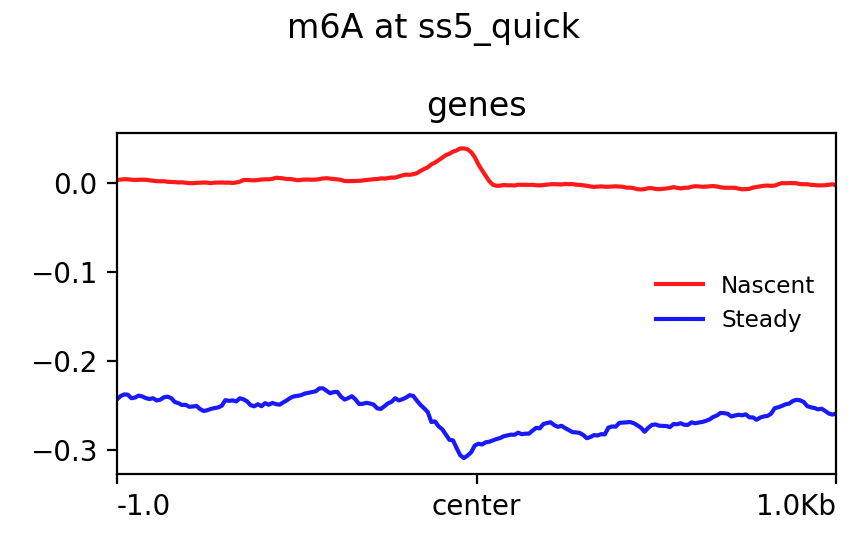

--- Processing ss3_quick ---

The following chromosome names did not match between the bigwig files
chromosome	length
           chrM	     16571
Result for ss3_quick:


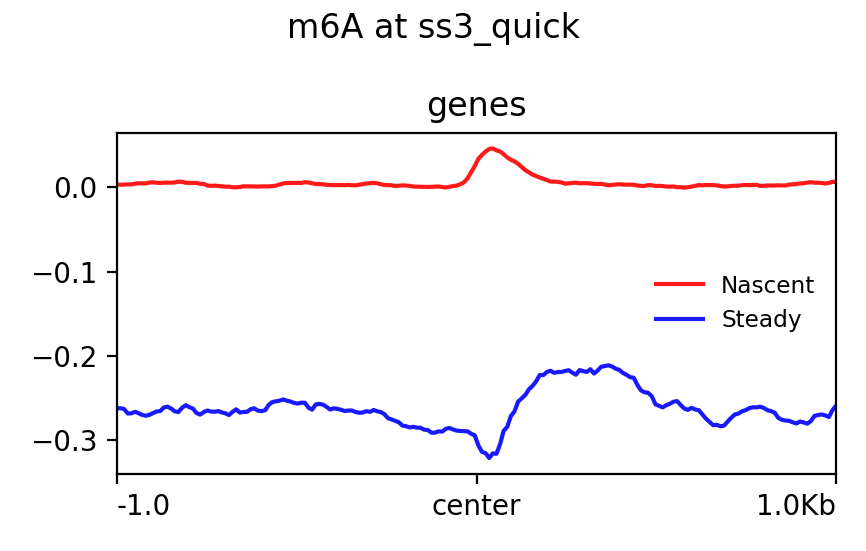

--- Processing starts_quick ---

The following chromosome names did not match between the bigwig files
chromosome	length
           chrM	     16571
Result for starts_quick:


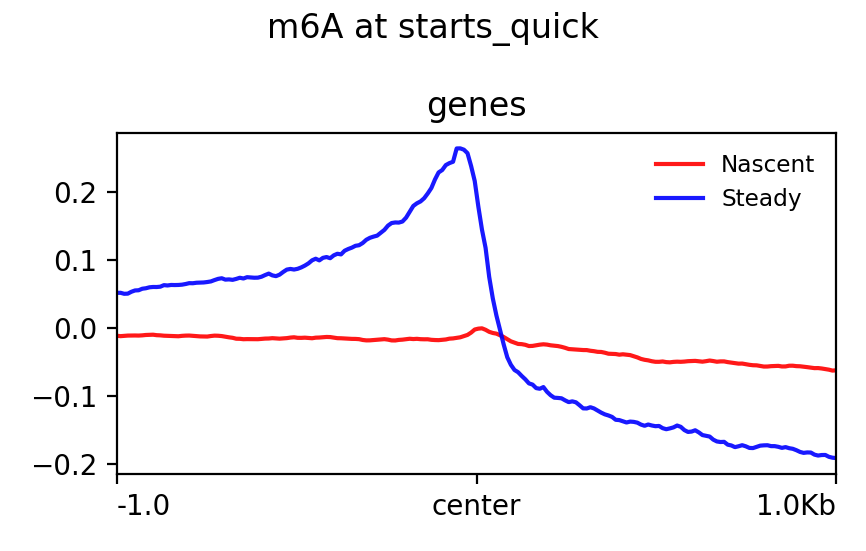

--- Processing stops_quick ---

The following chromosome names did not match between the bigwig files
chromosome	length
           chrM	     16571
Result for stops_quick:


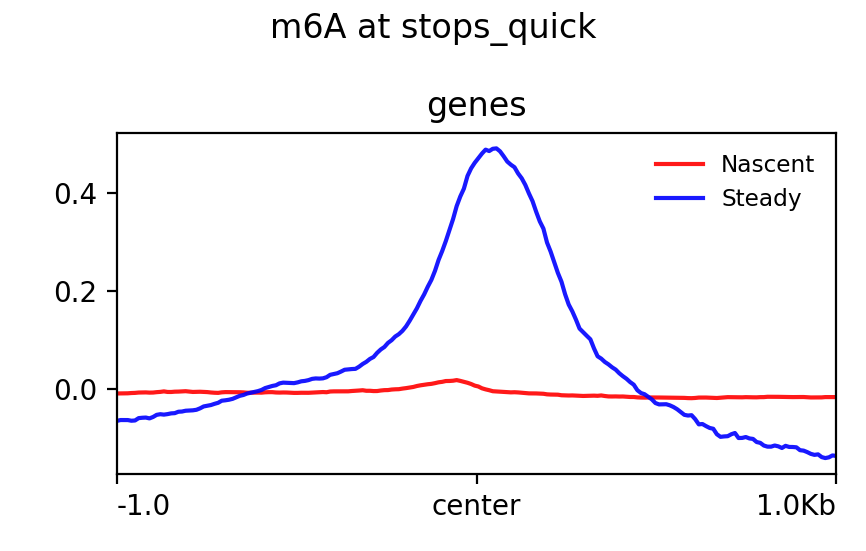

In [ ]:
from IPython.display import Image, display

landmarks = ["ss5_quick", "ss3_quick", "starts_quick", "stops_quick"]

for region in landmarks:
    print(f"--- Processing {region} ---")
    
    # 1. Calculate Matrix
    !computeMatrix reference-point --referencePoint center \
     --beforeRegionStartLength 1000 --afterRegionStartLength 1000 \
     --regionsFileName {region}.bed \
     --scoreFileName Nascent_Ratio.bw Steady_Ratio.bw \
     --outFileName matrix_{region}.gz \
     --numberOfProcessors 2 --quiet
    
    # 2. Plot
    !plotProfile -m matrix_{region}.gz -out Figure_1_{region}.png \
     --plotTitle "m6A at {region}" \
     --samplesLabel "Nascent" "Steady" \
     --colors red blue \
     --perGroup
    
    # 3. Display
    print(f"Result for {region}:")
    display(Image(filename=f'Figure_1_{region}.png'))


Conclusions:

Looking at the plots, we can see some differences between the Nascent RNA (red line) and the mature RNA (blue line), but not as clear as in the original paper.
In the Splice Site plots, the red line (Nascent) doesn't have the bump as high as it was expected right at the center, but just a very small peaks, I try a lot of changes in my code but I couldn't figure out why this happening in the first two plots. One the other hand the last to plots, look much better and similar to the original one from the paper, as they have a clear peak for steady RNA and a flat line for Nancent as it was expected. Maybe the problem has to do with the fact that I use only a small part of the original files for computational efficiency, since the whole files were too big for a laptop analysis.  